In [1]:
import numpy as np
import tensorflow as tf

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from PIL import Image

/Users/sudatakamune/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


手書き数字のデータセットmnistを設定 

In [36]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [37]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

In [38]:
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

mnistにはどんなモノが入っているのか可視化してみる

In [7]:
%matplotlib inline
def img_show(img):
    imshow(img)

img_show(train_data[6].reshape(28, 28))

NameError: name 'train_data' is not defined

モデルの設定

In [3]:
def cnn_model_fn(features, labels, mode):

    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## 訓練  
構築したモデルにmnistを入れ、訓練させる。

In [41]:
tf.logging.set_verbosity(tf.logging.INFO)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [52]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [53]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

In [4]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./model/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181755a748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


100stepごとに分けることで、学習させながら精度の変化を確認することができる。  
これを50回繰り返すので、計5000回学習させる。

In [55]:
for i in range(50):
    mnist_classifier.train(
        input_fn=train_input_fn,
        steps=100,
        hooks=[logging_hook])
    
    eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.00010478 0.9577225  0.01018857 0.00206941 0.00557796 0.00051821
  0.00075141 0.00059548 0.02227785 0.00019383]
 [0.00002881 0.00015321 0.00001782 0.00182545 0.07750048 0.00136045
  0.00002331 0.01276229 0.00656807 0.8997602 ]
 [0.00000032 0.00001249 0.9989268  0.000055   0.00001057 0.00000024
  0.00099365 0.00000011 0.00000079 0.00000009]
 [0.00129925 0.00000083 0.98729867 0.00778598 0.00005807 0.00006607
  0.00154941 0.0000002  0.00194105 0.00000031]
 [0.00249041 0.00000041 0.00007973 0.00414525 0.00000653 0.9715645
  0.01381908 0.         0.0078931

INFO:tensorflow:loss = 0.18268806, step = 26
INFO:tensorflow:probabilities = [[0.00003231 0.00000124 0.00013309 0.00064866 0.00002244 0.9371746
  0.00001516 0.0000119  0.06169032 0.00027024]
 [0.00002028 0.00049161 0.00005633 0.00003097 0.9932955  0.0002162
  0.00200494 0.00034698 0.00073316 0.00280408]
 [0.00000147 0.00002873 0.00003953 0.00000171 0.99890816 0.00002794
  0.00004179 0.00045975 0.00022153 0.00026948]
 [0.9904879  0.00000686 0.0011808  0.00003612 0.00028579 0.00051818
  0.00102144 0.00028567 0.00142139 0.00475597]
 [0.00020348 0.00043518 0.00204752 0.00435185 0.00283659 0.01617423
  0.00006431 0.07421709 0.04697059 0.85269916]
 [0.00002268 0.00000575 0.00001925 0.00008175 0.00093907 0.00500709
  0.00000377 0.00818886 0.00101133 0.98472047]
 [0.00007651 0.5287916  0.19727825 0.11785437 0.07023077 0.00100974
  0.00003858 0.01187984 0.06835434 0.004486  ]
 [0.98671293 0.00000024 0.00896521 0.00000201 0.00062595 0.00076682
  0.00191388 0.00002073 0.00041866 0.00057363]
 [0.0

INFO:tensorflow:Saving checkpoints for 125 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1873248.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:30:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:30:16
INFO:tensorflow:Saving dict for global step 125: accuracy = 0.9737, global_step = 125, loss = 0.08503195
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 125: ./model/mnist_convnet_model/model.ckpt-125
{'accuracy': 0.9737, 'loss': 0.08503195, 'global_step': 125}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameter

INFO:tensorflow:loss = 0.107593745, step = 126
INFO:tensorflow:probabilities = [[0.8380737  0.00002054 0.00153011 0.00001084 0.00005259 0.00004539
  0.15848012 0.00006747 0.00165596 0.00006328]
 [0.00270458 0.00011849 0.0144499  0.0001015  0.00845282 0.03462993
  0.53079605 0.00047761 0.37606883 0.03220035]
 [0.9999192  0.         0.00000002 0.         0.         0.00000001
  0.00008068 0.00000013 0.         0.00000001]
 [0.00001785 0.99923956 0.0000351  0.00000445 0.00019912 0.00000025
  0.00000204 0.000486   0.00000808 0.00000765]
 [0.0000003  0.00000028 0.00312052 0.99687433 0.00000022 0.000001
  0.0000001  0.00000072 0.00000226 0.0000002 ]
 [0.00002614 0.00000002 0.0000001  0.00000011 0.00000059 0.00037123
  0.99959975 0.         0.00000212 0.00000002]
 [0.00051919 0.00011451 0.9521382  0.00412314 0.0000059  0.000006
  0.00000606 0.0427885  0.00005252 0.00024595]
 [0.0000879  0.00023953 0.02357413 0.0017361  0.00001743 0.00001332
  0.00014582 0.00000479 0.974161   0.00002002]
 [0.9

INFO:tensorflow:Saving checkpoints for 225 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.074151725.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:30:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:30:51
INFO:tensorflow:Saving dict for global step 225: accuracy = 0.9783, global_step = 225, loss = 0.06296292
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 225: ./model/mnist_convnet_model/model.ckpt-225
{'accuracy': 0.9783, 'loss': 0.06296292, 'global_step': 225}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramet

INFO:tensorflow:loss = 0.12600163, step = 226
INFO:tensorflow:probabilities = [[0.00067898 0.00002134 0.00001067 0.00000627 0.00006406 0.01203861
  0.98677456 0.00000041 0.00040389 0.00000113]
 [0.00000003 0.0000006  0.00000788 0.00000159 0.00000026 0.00000002
  0.         0.999959   0.00000238 0.00002828]
 [0.00000036 0.9998863  0.0000475  0.00000003 0.00000401 0.
  0.00000076 0.00000289 0.00005817 0.00000001]
 [0.00000028 0.99992037 0.00001099 0.00000015 0.0000315  0.00000009
  0.00000422 0.00000894 0.00002347 0.00000007]
 [0.00000359 0.00000099 0.00000709 0.0000081  0.00002934 0.00001058
  0.00000003 0.99985063 0.00000501 0.00008461]
 [0.         0.         0.0000001  0.00006244 0.0005535  0.00011687
  0.         0.00001218 0.0001478  0.99910706]
 [0.01106071 0.03158552 0.09302908 0.00332085 0.00162097 0.00020829
  0.83466935 0.00001336 0.02448676 0.00000519]
 [0.2182921  0.00002973 0.7675902  0.00387679 0.00001933 0.00000507
  0.00036324 0.00028666 0.00945141 0.00008537]
 [0.000131

INFO:tensorflow:Saving checkpoints for 325 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.045550663.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:31:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:31:23
INFO:tensorflow:Saving dict for global step 325: accuracy = 0.9843, global_step = 325, loss = 0.050261952
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 325: ./model/mnist_convnet_model/model.ckpt-325
{'accuracy': 0.9843, 'loss': 0.050261952, 'global_step': 325}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring param

INFO:tensorflow:loss = 0.029556107, step = 326
INFO:tensorflow:probabilities = [[0.9990584  0.00000075 0.00008541 0.00000058 0.00000014 0.00000873
  0.00001322 0.00000366 0.00082587 0.00000327]
 [0.         0.         0.         0.9999639  0.         0.00003572
  0.         0.00000002 0.00000039 0.00000002]
 [0.00000063 0.00002834 0.00000336 0.00000029 0.00012574 0.00051793
  0.9989839  0.         0.00033977 0.00000001]
 [0.0000017  0.00000003 0.00000003 0.00004752 0.00000048 0.96980447
  0.01955722 0.         0.01055897 0.00002957]
 [0.00006357 0.99726284 0.0000246  0.0000023  0.0022031  0.00001354
  0.00012863 0.00009132 0.00020523 0.00000479]
 [0.         0.         0.         0.00000114 0.         0.9999002
  0.00000037 0.         0.00009811 0.00000012]
 [0.00000079 0.0000591  0.00000284 0.00010883 0.00018639 0.00001884
  0.         0.93816555 0.00002548 0.06143223]
 [0.00000001 0.00000024 0.00000009 0.00000008 0.99999475 0.0000001
  0.         0.00000186 0.0000007  0.00000211]
 [0

INFO:tensorflow:Saving checkpoints for 425 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0158584.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:31:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-425
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:31:58
INFO:tensorflow:Saving dict for global step 425: accuracy = 0.9858, global_step = 425, loss = 0.042443212
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 425: ./model/mnist_convnet_model/model.ckpt-425
{'accuracy': 0.9858, 'loss': 0.042443212, 'global_step': 425}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramet

INFO:tensorflow:loss = 0.040000107, step = 426
INFO:tensorflow:probabilities = [[0.         0.00000007 0.         0.         0.9999989  0.00000002
  0.         0.00000017 0.00000047 0.00000031]
 [0.999762   0.00000024 0.00005477 0.00000003 0.00000094 0.0000142
  0.00011092 0.0000287  0.00000885 0.00001945]
 [0.00000015 0.00000023 0.00000303 0.00088488 0.00000056 0.9986104
  0.00006536 0.00000002 0.0003571  0.0000783 ]
 [0.00000025 0.00000243 0.00000033 0.00000932 0.00000054 0.00000013
  0.         0.9999347  0.00000139 0.00005101]
 [0.00008089 0.00000017 0.9996184  0.00005101 0.00013439 0.00000222
  0.00000072 0.00003318 0.00002151 0.00005749]
 [0.00000377 0.01045479 0.00014816 0.00111358 0.8889006  0.00165059
  0.00002925 0.001529   0.00070688 0.0954634 ]
 [0.00000259 0.00000984 0.9996141  0.00012715 0.00000064 0.
  0.00000009 0.00003101 0.0002145  0.00000005]
 [0.00000655 0.00000005 0.9995241  0.00000613 0.00000426 0.00000003
  0.00000012 0.00000912 0.00044927 0.00000023]
 [0.0000111

INFO:tensorflow:Saving checkpoints for 525 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.034670684.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:32:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:32:26
INFO:tensorflow:Saving dict for global step 525: accuracy = 0.9856, global_step = 525, loss = 0.041973587
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 525: ./model/mnist_convnet_model/model.ckpt-525
{'accuracy': 0.9856, 'loss': 0.041973587, 'global_step': 525}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring param

INFO:tensorflow:loss = 0.07249206, step = 526
INFO:tensorflow:probabilities = [[0.         0.         0.         0.0000001  0.         0.99999917
  0.00000027 0.00000003 0.00000042 0.00000005]
 [0.00000007 0.00008868 0.1436987  0.8258678  0.00000727 0.00000015
  0.00000001 0.02999207 0.00028783 0.00005749]
 [0.99999917 0.         0.00000015 0.         0.         0.
  0.00000067 0.         0.00000002 0.        ]
 [0.00000223 0.0000002  0.99993205 0.00000116 0.00006334 0.
  0.00000003 0.0000002  0.00000085 0.00000002]
 [0.99999964 0.         0.00000013 0.         0.         0.00000001
  0.00000008 0.00000005 0.         0.00000001]
 [0.00000023 0.         0.00000001 0.         0.00000239 0.00000002
  0.9999974  0.         0.00000002 0.        ]
 [0.0000055  0.9999628  0.00001661 0.00000007 0.00000572 0.00000004
  0.00000097 0.00000718 0.00000107 0.00000006]
 [0.00000717 0.99572104 0.00007535 0.00000133 0.00017471 0.00000034
  0.00000402 0.00400878 0.00000575 0.00000148]
 [0.00000021 0.000

INFO:tensorflow:Saving checkpoints for 625 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.02588136.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:32:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:32:53
INFO:tensorflow:Saving dict for global step 625: accuracy = 0.9863, global_step = 625, loss = 0.03985641
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 625: ./model/mnist_convnet_model/model.ckpt-625
{'accuracy': 0.9863, 'loss': 0.03985641, 'global_step': 625}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramete

INFO:tensorflow:loss = 0.07433057, step = 626
INFO:tensorflow:probabilities = [[0.9999765  0.00000001 0.0000232  0.00000002 0.         0.00000001
  0.00000014 0.         0.00000007 0.00000002]
 [0.         0.0000007  0.00000001 0.00000074 0.00004716 0.00000365
  0.         0.00018474 0.00002835 0.9997346 ]
 [0.9994747  0.00000137 0.00047492 0.00000196 0.00000002 0.00000003
  0.00001354 0.00000011 0.00003322 0.00000019]
 [0.00000004 0.         0.00000001 0.00000001 0.00000004 0.00001609
  0.99997365 0.         0.00001007 0.        ]
 [0.         0.         0.9999999  0.00000001 0.         0.
  0.         0.00000001 0.0000001  0.        ]
 [0.01174939 0.00000003 0.00000033 0.         0.00000012 0.00000027
  0.9882472  0.         0.00000256 0.00000001]
 [0.00001787 0.00000106 0.00000258 0.00000001 0.00113067 0.00002421
  0.9988164  0.00000001 0.00000724 0.00000001]
 [1.         0.         0.         0.         0.         0.
  0.00000002 0.         0.         0.        ]
 [0.00005323 0.000

INFO:tensorflow:Saving checkpoints for 725 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.08009749.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:33:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:33:21
INFO:tensorflow:Saving dict for global step 725: accuracy = 0.986, global_step = 725, loss = 0.041531604
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 725: ./model/mnist_convnet_model/model.ckpt-725
{'accuracy': 0.986, 'loss': 0.041531604, 'global_step': 725}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramete

INFO:tensorflow:loss = 0.09531625, step = 726
INFO:tensorflow:probabilities = [[0.00000002 0.00000002 0.         0.00006766 0.00000001 0.9999038
  0.00000017 0.         0.00000653 0.00002171]
 [0.00000023 0.9999573  0.00000733 0.00000013 0.00000435 0.00000011
  0.00000058 0.00000079 0.00002904 0.00000008]
 [0.00003261 0.0000243  0.00000042 0.00000003 0.9989324  0.00000196
  0.00011517 0.00089046 0.00000177 0.00000083]
 [0.         0.         0.         0.         0.99999714 0.
  0.         0.00000228 0.00000037 0.0000002 ]
 [0.00000005 0.00000008 0.00000051 0.00001043 0.0000047  0.00004274
  0.00000162 0.00000039 0.99993384 0.00000562]
 [0.00000002 0.00000095 0.99999905 0.00000005 0.         0.
  0.         0.         0.00000003 0.        ]
 [0.01908652 0.50000155 0.01506509 0.0010069  0.39964482 0.00028482
  0.00520151 0.00811441 0.04989134 0.00170307]
 [0.         0.         0.00000001 0.00000055 0.00000608 0.00000005
  0.         0.00004948 0.00002861 0.99991524]
 [0.99961996 0.0000

INFO:tensorflow:Saving checkpoints for 825 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.01959386.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:33:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:33:48
INFO:tensorflow:Saving dict for global step 825: accuracy = 0.9888, global_step = 825, loss = 0.032147817
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 825: ./model/mnist_convnet_model/model.ckpt-825
{'accuracy': 0.9888, 'loss': 0.032147817, 'global_step': 825}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parame

INFO:tensorflow:loss = 0.06460304, step = 826
INFO:tensorflow:probabilities = [[0.         0.00000017 0.         0.         0.9999999  0.
  0.00000004 0.         0.         0.        ]
 [0.00000002 0.         0.         0.         0.         0.
  0.         0.99999714 0.         0.00000288]
 [0.         0.         0.         0.00000001 0.         0.
  0.         0.         0.9999999  0.00000017]
 [1.         0.00000001 0.         0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.         0.00000028 0.00000341 0.9999256  0.         0.00000001
  0.         0.00002323 0.00004742 0.        ]
 [0.00000278 0.00000018 0.00000001 0.         0.0000001  0.00005935
  0.99993587 0.         0.0000018  0.        ]
 [0.00000009 0.00014005 0.         0.00000143 0.0081483  0.00164897
  0.00000004 0.0010819  0.00047465 0.9885046 ]
 [0.         0.         0.         0.         0.99999714 0.
  0.         0.00000018 0.00000045 0.00000219]
 [0.         0.         0.         0.99999

INFO:tensorflow:Saving checkpoints for 925 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.03320524.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:34:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:34:16
INFO:tensorflow:Saving dict for global step 925: accuracy = 0.9907, global_step = 925, loss = 0.028933048
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 925: ./model/mnist_convnet_model/model.ckpt-925
{'accuracy': 0.9907, 'loss': 0.028933048, 'global_step': 925}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parame

INFO:tensorflow:loss = 0.014785368, step = 926
INFO:tensorflow:probabilities = [[0.         0.00000039 0.         0.00008193 0.00000002 0.9994523
  0.00001915 0.         0.00001692 0.00042925]
 [0.         0.00000002 0.         0.00000002 0.00001637 0.
  0.         0.00000074 0.00000022 0.9999826 ]
 [0.         0.00000241 0.         0.00000001 0.99997914 0.00000001
  0.00000005 0.00000023 0.00000616 0.00001206]
 [0.00000799 0.00000001 0.99998665 0.00000513 0.         0.
  0.         0.00000004 0.00000017 0.00000002]
 [0.00000002 0.00000001 0.00000049 0.9999863  0.         0.0000113
  0.00000002 0.00000001 0.00000191 0.00000004]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.0000004  0.         0.         0.00000071
  0.00000024 0.         0.9999987  0.        ]
 [1.         0.         0.00000001 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         

INFO:tensorflow:Saving checkpoints for 1025 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.011786337.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:34:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:34:43
INFO:tensorflow:Saving dict for global step 1025: accuracy = 0.9902, global_step = 1025, loss = 0.029102014
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1025: ./model/mnist_convnet_model/model.ckpt-1025
{'accuracy': 0.9902, 'loss': 0.029102014, 'global_step': 1025}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.054061417, step = 1026
INFO:tensorflow:probabilities = [[0.00000005 0.00000034 0.00000041 0.00000002 0.00000206 0.00000481
  0.         0.9999895  0.00000045 0.00000241]
 [0.00000001 0.00002846 0.0000002  0.00000012 0.4746023  0.00001309
  0.00000001 0.00000762 0.0040106  0.5213376 ]
 [0.         0.         0.         0.99999464 0.         0.0000053
  0.         0.00000005 0.00000002 0.00000004]
 [0.00000001 0.00002625 0.00012386 0.00000075 0.00000083 0.00000001
  0.         0.99984384 0.0000016  0.00000292]
 [0.0000489  0.00000005 0.00000054 0.00000002 0.00000603 0.00004654
  0.99989676 0.         0.00000099 0.00000008]
 [0.00000075 0.99749655 0.00001567 0.00000008 0.00205299 0.00000116
  0.00002382 0.00034702 0.00004533 0.00001661]
 [0.00004464 0.00000888 0.00306541 0.00006615 0.00000043 0.00000381
  0.00000017 0.00005569 0.9966786  0.0000763 ]
 [0.         0.00000025 0.00001028 0.00000715 0.00000313 0.
  0.         0.9999789  0.00000016 0.00000017]
 [0.00000

INFO:tensorflow:Saving checkpoints for 1125 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.038564738.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:35:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:35:11
INFO:tensorflow:Saving dict for global step 1125: accuracy = 0.9868, global_step = 1125, loss = 0.0389226
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1125: ./model/mnist_convnet_model/model.ckpt-1125
{'accuracy': 0.9868, 'loss': 0.0389226, 'global_step': 1125}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:loss = 0.10240011, step = 1126
INFO:tensorflow:probabilities = [[0.         0.         0.         1.         0.         0.00000001
  0.         0.         0.         0.        ]
 [1.         0.         0.00000001 0.         0.         0.00000002
  0.         0.         0.         0.00000001]
 [0.         0.00000024 0.00000048 0.         0.9999969  0.00000001
  0.00000065 0.         0.00000174 0.00000002]
 [0.00008752 0.00882198 0.00005823 0.09126715 0.03311987 0.052256
  0.00000243 0.29142994 0.0000863  0.5228706 ]
 [0.00000001 0.00000028 0.00000001 0.00001165 0.00040517 0.00000069
  0.         0.0000018  0.00002517 0.9995552 ]
 [0.00000001 0.00000009 0.         0.18787861 0.00000001 0.8113063
  0.00000003 0.00000457 0.00000226 0.00080809]
 [0.0000051  0.9993044  0.00001132 0.00000204 0.00037541 0.00004922
  0.00000928 0.00002852 0.000181   0.00003376]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000692

INFO:tensorflow:Saving checkpoints for 1225 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.008551469.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:35:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:35:41
INFO:tensorflow:Saving dict for global step 1225: accuracy = 0.9895, global_step = 1225, loss = 0.0307162
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1225: ./model/mnist_convnet_model/model.ckpt-1225
{'accuracy': 0.9895, 'loss': 0.0307162, 'global_step': 1225}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:loss = 0.014496793, step = 1226
INFO:tensorflow:probabilities = [[0.00001431 0.00000089 0.00001568 0.00000601 0.00000044 0.00000686
  0.         0.9994773  0.00000471 0.00047392]
 [0.         0.00000038 0.00000307 0.00000004 0.99069256 0.00000007
  0.00000001 0.00003831 0.00000601 0.00925961]
 [0.00074285 0.9562121  0.00045083 0.00001502 0.03908784 0.00026626
  0.00047942 0.00232086 0.00037861 0.00004618]
 [0.99999964 0.         0.00000012 0.00000005 0.         0.00000001
  0.         0.         0.00000001 0.00000017]
 [0.00002152 0.99989057 0.0000041  0.00000001 0.00005686 0.00000019
  0.00000053 0.00002476 0.00000143 0.00000003]
 [0.00000006 0.00000021 0.00000018 0.00000497 0.         0.00000024
  0.         0.99999416 0.         0.0000001 ]
 [0.00068359 0.0000001  0.00000001 0.00000138 0.00000306 0.00960071
  0.9895796  0.         0.00012974 0.00000175]
 [0.00000005 0.00000002 0.00000001 0.00000723 0.00000373 0.01898214
  0.98099595 0.         0.00001096 0.00000001]


INFO:tensorflow:Saving checkpoints for 1325 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.010841931.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:36:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:36:11
INFO:tensorflow:Saving dict for global step 1325: accuracy = 0.9874, global_step = 1325, loss = 0.03697471
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1325: ./model/mnist_convnet_model/model.ckpt-1325
{'accuracy': 0.9874, 'loss': 0.03697471, 'global_step': 1325}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

INFO:tensorflow:loss = 0.014797054, step = 1326
INFO:tensorflow:probabilities = [[0.00000041 0.00000014 0.00000302 0.00000004 0.00000159 0.00000111
  0.00000524 0.00000057 0.999987   0.00000082]
 [0.         0.9999995  0.         0.         0.00000053 0.
  0.         0.00000003 0.00000001 0.        ]
 [0.00000007 0.         0.         0.         0.00000019 0.00000002
  0.99999976 0.         0.         0.        ]
 [0.01319158 0.01590564 0.0267938  0.0111715  0.00135148 0.00589895
  0.1264534  0.00015645 0.7886611  0.01041611]
 [0.00000067 0.9999405  0.00000113 0.00000044 0.00005475 0.00000185
  0.         0.         0.00000005 0.00000053]
 [0.9999994  0.         0.00000004 0.         0.         0.
  0.00000002 0.00000002 0.00000051 0.00000004]
 [0.99999523 0.         0.00000471 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00000002 0.00000007
  0.         0.         0.00000001 0.9999999 ]
 [0.         0.00000051 

INFO:tensorflow:Saving checkpoints for 1425 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00514657.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:36:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1425
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:36:46
INFO:tensorflow:Saving dict for global step 1425: accuracy = 0.9919, global_step = 1425, loss = 0.025130043
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1425: ./model/mnist_convnet_model/model.ckpt-1425
{'accuracy': 0.9919, 'loss': 0.025130043, 'global_step': 1425}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:loss = 0.0053323936, step = 1426
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000012 0.0000021  0.000141   0.00000642
  0.         0.00004671 0.0000234  0.99978024]
 [0.         0.         1.         0.00000005 0.         0.
  0.         0.         0.00000004 0.        ]
 [0.         0.00000024 0.         0.01286924 0.00000001 0.98709375
  0.00000114 0.00000001 0.00000018 0.00003538]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00000003 0.         0.00000001 0.0000016  0.00000002 0.00000245
  0.00000281 0.         0.9999919  0.00000115]
 [0.00000076 0.999998   0.00000001 0.00000005 0.00000022 0.00000006
  0.0000001  0.00000005 0.00000015 0.00000063]
 [0.00000008 0.00000345 0.00021762 0.000012   0.00000053 0.00000002
  0.         0.9997298  0.00001539 0.00002105]
 [0.00000016 0.0000008  0.99999905 0.00000001 0.         0.
  0.         0.         0.         0.        ]
 [0.00002117 0.999203  

INFO:tensorflow:Saving checkpoints for 1525 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.022543216.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:37:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:37:23
INFO:tensorflow:Saving dict for global step 1525: accuracy = 0.9906, global_step = 1525, loss = 0.024782257
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1525: ./model/mnist_convnet_model/model.ckpt-1525
{'accuracy': 0.9906, 'loss': 0.024782257, 'global_step': 1525}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.009239222, step = 1526
INFO:tensorflow:probabilities = [[0.99999106 0.00000002 0.00000373 0.         0.00000001 0.00000014
  0.00000051 0.00000335 0.00000062 0.0000006 ]
 [0.0000001  0.9999949  0.00000278 0.         0.00000107 0.00000003
  0.00000001 0.00000081 0.0000003  0.00000001]
 [0.00001215 0.9788488  0.00001138 0.00002386 0.0175206  0.00071076
  0.00000879 0.00020812 0.00018403 0.00247157]
 [0.00000012 0.9995363  0.00003561 0.         0.00034796 0.00000007
  0.0000001  0.0000312  0.00004854 0.00000005]
 [0.0000003  0.99994075 0.00000004 0.         0.00002464 0.00002872
  0.00000159 0.00000255 0.00000137 0.00000002]
 [0.         0.         0.00000001 0.         0.         0.00000115
  0.9999988  0.         0.00000001 0.        ]
 [0.9999988  0.         0.00000073 0.         0.         0.
  0.         0.00000001 0.00000011 0.00000031]
 [0.9993368  0.00000002 0.00005136 0.00000004 0.00000099 0.00000756
  0.00000701 0.0000004  0.00005125 0.0005446 ]
 [0.9996

INFO:tensorflow:Saving checkpoints for 1625 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.006857979.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:37:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:37:55
INFO:tensorflow:Saving dict for global step 1625: accuracy = 0.9916, global_step = 1625, loss = 0.02450117
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1625: ./model/mnist_convnet_model/model.ckpt-1625
{'accuracy': 0.9916, 'loss': 0.02450117, 'global_step': 1625}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

INFO:tensorflow:loss = 0.020337746, step = 1626
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.00000001 0.00000005
  1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00000017 0.00000003 0.         0.00000001
  0.         0.         0.99999845 0.00000137]
 [0.         0.         0.         0.         0.         0.00000002
  1.         0.         0.         0.        ]
 [1.         0.         0.00000001 0.         0.         0.
  0.         0.00000001 0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.00000002 0.9999994  0.00000003 0.         0.00000016 0.00000002
  0.00000001 0.0000002  0.0000001  0.        ]
 [0.         0.         0.         0.00000001 0.         0.9999999
  0.         0.         0.         0.00000014]
 [0.00000011 0.00000067 0

INFO:tensorflow:Saving checkpoints for 1725 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0101731755.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:38:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:38:23
INFO:tensorflow:Saving dict for global step 1725: accuracy = 0.9916, global_step = 1725, loss = 0.02574985
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1725: ./model/mnist_convnet_model/model.ckpt-1725
{'accuracy': 0.9916, 'loss': 0.02574985, 'global_step': 1725}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:loss = 0.043963403, step = 1726
INFO:tensorflow:probabilities = [[0.9999987  0.         0.00000131 0.         0.         0.
  0.         0.         0.         0.00000001]
 [0.         1.         0.         0.         0.00000004 0.
  0.         0.00000003 0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 0.00000005 0.         0.00000003 0.00038403 0.00000004
  0.         0.00000057 0.00256244 0.9970528 ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.00000001]
 [1.         0.         0.00000001 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.         0.00000006 0.         0.         0.
  0.00000001 0.         0.00000017 0.00000002]
 [0.         0.9999882  0.00000003 0.00000005 0.00001159

INFO:tensorflow:Saving checkpoints for 1825 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.010249323.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:38:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:38:53
INFO:tensorflow:Saving dict for global step 1825: accuracy = 0.9905, global_step = 1825, loss = 0.028930278
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1825: ./model/mnist_convnet_model/model.ckpt-1825
{'accuracy': 0.9905, 'loss': 0.028930278, 'global_step': 1825}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.0026187156, step = 1826
INFO:tensorflow:probabilities = [[0.99965787 0.         0.0000007  0.         0.00000048 0.
  0.00033124 0.         0.0000079  0.00000183]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.00000003 0.00000155 0.         0.9986488
  0.00052888 0.         0.00082068 0.00000003]
 [0.         0.         0.         0.00000011 0.         0.9999993
  0.         0.         0.         0.00000064]
 [0.         0.         0.         0.999992   0.         0.00000187
  0.         0.         0.00000603 0.00000001]
 [0.         0.9999995  0.         0.         0.00000006 0.00000025
  0.00000001 0.         0.00000008 0.        ]
 [0.00000094 0.000001   0.00001758 0.00000024 0.00000334 0.00001556
  0.00000171 0.00000589 0.99994314 0.00001059]
 [0.00000012 0.00000762 0.00000001 0.00000176 0.00016597 0.9023088
  0.00000003 0.09731919 0.00011189 0.00008461]
 [0.         0.999

INFO:tensorflow:Saving checkpoints for 1925 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0085620675.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:39:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-1925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:39:26
INFO:tensorflow:Saving dict for global step 1925: accuracy = 0.9914, global_step = 1925, loss = 0.025625117
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1925: ./model/mnist_convnet_model/model.ckpt-1925
{'accuracy': 0.9914, 'loss': 0.025625117, 'global_step': 1925}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.047509402, step = 1926
INFO:tensorflow:probabilities = [[0.00000003 0.9999943  0.00000001 0.         0.00000057 0.00000002
  0.00000001 0.00000001 0.00000516 0.00000003]
 [0.         0.00000001 0.         0.         0.9998702  0.
  0.         0.00000249 0.00000002 0.00012724]
 [0.00000001 0.         0.         0.00000001 0.         0.
  0.         0.00000003 0.00000007 0.99999976]
 [0.00001424 0.99998164 0.00000015 0.         0.00000006 0.00000027
  0.0000033  0.00000011 0.00000026 0.        ]
 [0.         0.         0.         0.0000001  0.         0.9999988
  0.         0.         0.         0.00000102]
 [0.00000001 0.00000011 0.00000001 0.00000286 0.00001085 0.00000011
  0.         0.00000017 0.00012905 0.9998568 ]
 [0.         1.         0.00000003 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.00000057 0.       

INFO:tensorflow:Saving checkpoints for 2025 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.013246704.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:39:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:40:02
INFO:tensorflow:Saving dict for global step 2025: accuracy = 0.9909, global_step = 2025, loss = 0.034147464
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2025: ./model/mnist_convnet_model/model.ckpt-2025
{'accuracy': 0.9909, 'loss': 0.034147464, 'global_step': 2025}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.0044427575, step = 2026
INFO:tensorflow:probabilities = [[0.9996222  0.00000011 0.00030256 0.00000009 0.00000002 0.00000063
  0.00000428 0.00003223 0.00003752 0.00000038]
 [1.         0.         0.         0.         0.         0.
  0.00000004 0.         0.00000002 0.        ]
 [0.00000064 0.00003247 0.0000003  0.00000229 0.00036063 0.00024547
  0.00000003 0.0058362  0.00005013 0.99347186]
 [0.00000001 0.00002491 0.9999708  0.00000174 0.0000017  0.
  0.00000016 0.00000013 0.00000052 0.00000005]
 [0.00000006 0.9999044  0.00000052 0.00000037 0.00001076 0.00000151
  0.00000008 0.00002497 0.00004449 0.00001276]
 [0.00000001 0.00000002 0.00000558 0.00144182 0.00000017 0.00026569
  0.00003049 0.00000001 0.99825066 0.00000549]
 [0.00000127 0.9999201  0.00000014 0.00000006 0.00000299 0.00000011
  0.00000769 0.00003128 0.00003632 0.00000001]
 [0.         0.00000006 0.00000003 0.         0.86183953 0.
  0.         0.00000001 0.0000023  0.1381581 ]
 [0.00000001 0.00000022

INFO:tensorflow:Saving checkpoints for 2125 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.024960509.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:40:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:40:34
INFO:tensorflow:Saving dict for global step 2125: accuracy = 0.9911, global_step = 2125, loss = 0.025815574
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2125: ./model/mnist_convnet_model/model.ckpt-2125
{'accuracy': 0.9911, 'loss': 0.025815574, 'global_step': 2125}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.03228875, step = 2126
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000032 0.         0.         0.         0.         0.00000363
  0.99999607 0.         0.00000003 0.        ]
 [0.         0.00000002 0.00000007 0.00000099 0.00006525 0.0000013
  0.         0.00000135 0.00003583 0.9998951 ]
 [0.         0.         0.         0.00002436 0.00000361 0.00001061
  0.         0.00023542 0.00000019 0.99972576]
 [0.00000216 0.0000001  0.99918383 0.00000002 0.00000002 0.
  0.         0.00081236 0.00000155 0.00000003]
 [0.9999993  0.00000008 0.00000049 0.         0.         0.
  0.00000002 0.         0.00000009 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.00000001 0.9999993  0.00000001 0.     

INFO:tensorflow:Saving checkpoints for 2225 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0025797992.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:40:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:41:05
INFO:tensorflow:Saving dict for global step 2225: accuracy = 0.9923, global_step = 2225, loss = 0.021431616
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2225: ./model/mnist_convnet_model/model.ckpt-2225
{'accuracy': 0.9923, 'loss': 0.021431616, 'global_step': 2225}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.036575213, step = 2226
INFO:tensorflow:probabilities = [[0.00000002 0.         0.         0.         0.0000005  0.
  0.         0.00000001 0.00000004 0.9999995 ]
 [0.         0.         0.         0.00000003 0.         0.99998593
  0.00000003 0.00000001 0.00000003 0.00001401]
 [0.         0.         0.00000001 0.         0.         0.
  0.         0.         1.         0.00000002]
 [0.00000009 0.00005406 0.00005502 0.00000068 0.99966466 0.00006248
  0.00000626 0.00011571 0.00004089 0.00000013]
 [0.         0.00000001 0.         0.         0.9999994  0.00000016
  0.00000001 0.00000021 0.00000021 0.00000001]
 [0.00000001 0.00000007 0.00000003 0.9999995  0.         0.00000012
  0.         0.00000025 0.00000001 0.00000002]
 [0.         0.         0.         0.         0.         0.
  0.         0.00000286 0.         0.99999714]
 [0.         0.00000005 0.00000005 0.00000013 0.999567   0.00000564
  0.         0.00042687 0.00000006 0.00000027]
 [0.         0.00000052 

INFO:tensorflow:Saving checkpoints for 2325 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0079899365.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:41:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:41:39
INFO:tensorflow:Saving dict for global step 2325: accuracy = 0.9916, global_step = 2325, loss = 0.022887887
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2325: ./model/mnist_convnet_model/model.ckpt-2325
{'accuracy': 0.9916, 'loss': 0.022887887, 'global_step': 2325}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.013701418, step = 2326
INFO:tensorflow:probabilities = [[0.99931693 0.         0.00000045 0.         0.         0.00000177
  0.00068035 0.         0.00000044 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000005 0.9999999  0.00000009 0.         0.
  0.         0.         0.00000003 0.        ]
 [0.00000004 0.00000013 0.00012043 0.00000067 0.         0.00000239
  0.00000093 0.00000001 0.9998754  0.        ]
 [0.         0.         0.         0.         0.         0.00000061
  0.9999994  0.         0.         0.        ]
 [0.         0.         0.         0.00000004 0.00000034 0.00000001
  0.         0.00000027 0.00000078 0.99999845]
 [0.         0.00000003 0.00000329 0.00000012 0.00000024 0.
  0.         0.9999962  0.00000002 0.00000008]
 [0.         0.         0.         0.         0.         0.00000006
  1.         0.         0.         0.        ]
 [0.         0.         

INFO:tensorflow:Saving checkpoints for 2425 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0066884444.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:42:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2425
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:42:07
INFO:tensorflow:Saving dict for global step 2425: accuracy = 0.993, global_step = 2425, loss = 0.023848968
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2425: ./model/mnist_convnet_model/model.ckpt-2425
{'accuracy': 0.993, 'loss': 0.023848968, 'global_step': 2425}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:loss = 0.009413604, step = 2426
INFO:tensorflow:probabilities = [[0.00001529 0.00000016 0.00004513 0.00000053 0.         0.00000001
  0.00000003 0.00000001 0.99993885 0.00000003]
 [0.00000001 0.99984396 0.         0.         0.00000012 0.
  0.         0.00015587 0.         0.        ]
 [0.         0.00000005 0.00002424 0.99997497 0.         0.00000001
  0.         0.00000032 0.0000004  0.00000003]
 [0.         0.         0.00000012 0.99999845 0.         0.
  0.         0.00000124 0.00000025 0.00000001]
 [0.00000002 0.         0.         0.         0.         0.00000045
  0.9999995  0.         0.         0.        ]
 [0.99999976 0.         0.         0.         0.         0.
  0.         0.00000008 0.         0.0000001 ]
 [0.00000031 0.         0.         0.00000001 0.0000063  0.00000001
  0.         0.01186319 0.00000092 0.9881293 ]
 [0.         0.00000001 0.00000067 0.99998605 0.         0.
  0.         0.00001296 0.00000021 0.        ]
 [0.         0.         0.      

INFO:tensorflow:Saving checkpoints for 2525 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.007958398.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:42:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:42:39
INFO:tensorflow:Saving dict for global step 2525: accuracy = 0.993, global_step = 2525, loss = 0.021097496
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2525: ./model/mnist_convnet_model/model.ckpt-2525
{'accuracy': 0.993, 'loss': 0.021097496, 'global_step': 2525}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

INFO:tensorflow:loss = 0.122426376, step = 2526
INFO:tensorflow:probabilities = [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 0.         0.         0.         0.         0.00002773
  0.999972   0.         0.0000002  0.        ]
 [0.         0.00000044 0.         0.         0.         0.
  0.         0.9999995  0.         0.00000002]
 [0.         0.         0.         0.         0.         0.9998266
  0.         0.         0.00000001 0.0001734 ]
 [0.         0.00000287 0.         0.0000001  0.00071138 0.00021956
  0.         0.00000025 0.0000003  0.99906546]
 [0.         0.00000046 0.         0.00747523 0.00000002 0.9925052
  0.0000036  0.         0.00000212 0.00001334]
 [0.00000054 0.         0.00000004 0.00000001 0.00000003 0.00093521
  0.9990626  0.         0.0000015  0.        ]
 [0.         0.         0.         0.9999995  0.         0.00000006
  0.         0.         0.00000037 0.00000001]
 [0.00001316 0.000

INFO:tensorflow:Saving checkpoints for 2625 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.011573398.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:43:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:43:11
INFO:tensorflow:Saving dict for global step 2625: accuracy = 0.9911, global_step = 2625, loss = 0.028887924
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2625: ./model/mnist_convnet_model/model.ckpt-2625
{'accuracy': 0.9911, 'loss': 0.028887924, 'global_step': 2625}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.0022011793, step = 2626
INFO:tensorflow:probabilities = [[0.00000005 0.9999974  0.00000017 0.00000001 0.00000041 0.00000004
  0.         0.00000188 0.0000001  0.00000002]
 [0.00000001 0.00000083 0.99999917 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000001 0.00000007 0.00000251 0.         0.00000338
  0.         0.99999213 0.         0.00000189]
 [0.00000003 0.99999917 0.00000002 0.         0.00000013 0.
  0.         0.00000058 0.         0.        ]
 [0.950395   0.0000434  0.00067651 0.0016419  0.00000215 0.00327303
  0.00011737 0.00018324 0.0354244  0.00824301]
 [0.         0.99999917 0.00000002 0.         0.00000003 0.
  0.         0.00000079 0.00000001 0.        ]
 [0.         0.9999932  0.         0.         0.00000009 0.
  0.         0.00000658 0.         0.00000012]
 [0.00000012 0.         0.99999976 0.00000009 0.         0.
  0.         0.00000001 0.         0.        ]
 [0.         0.         1.         0.  

INFO:tensorflow:Saving checkpoints for 2725 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00074398844.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:43:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:43:39
INFO:tensorflow:Saving dict for global step 2725: accuracy = 0.9916, global_step = 2725, loss = 0.025219526
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2725: ./model/mnist_convnet_model/model.ckpt-2725
{'accuracy': 0.9916, 'loss': 0.025219526, 'global_step': 2725}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restor

INFO:tensorflow:loss = 0.010271905, step = 2726
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.         0.99999976 0.
  0.00000018 0.         0.00000002 0.        ]
 [0.         0.9999976  0.         0.         0.00000227 0.
  0.00000001 0.00000016 0.00000002 0.        ]
 [0.         0.         0.         0.         0.         0.00000002
  0.         0.         1.         0.        ]
 [0.99978775 0.00000003 0.00000043 0.00000005 0.00000049 0.00013009
  0.00007315 0.00000096 0.00000626 0.0000009 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.00005921 0.00008512 0.00113617 0.00001208 0.0000026
  0.00000001 0.9986731  0.00000126 0.00003036]
 [0.         0.99999976 0.00000001 0.         0.00000007 0.
  0.00000018 0.         0.00000001 0.        ]
 [0.         0.         0.         0.00386477 0.         0.9961009
  0.         0.         0.00002682 0.00000755]
 [0.         0.         0.        

INFO:tensorflow:Saving checkpoints for 2825 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0012240133.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:44:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:44:09
INFO:tensorflow:Saving dict for global step 2825: accuracy = 0.9914, global_step = 2825, loss = 0.025566952
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2825: ./model/mnist_convnet_model/model.ckpt-2825
{'accuracy': 0.9914, 'loss': 0.025566952, 'global_step': 2825}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.015534594, step = 2826
INFO:tensorflow:probabilities = [[0.99999964 0.         0.         0.         0.00000001 0.00000001
  0.00000025 0.         0.00000008 0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.00000002 0.        ]
 [0.         0.         0.00000102 0.00000001 0.         0.
  0.         0.00000001 0.9999989  0.00000001]
 [0.         0.         0.         0.00000001 0.         0.9999999
  0.         0.         0.00000013 0.        ]
 [0.         0.         0.00000001 0.         0.         0.
  0.         1.         0.         0.        ]
 [0.00000015 0.9999968  0.00000004 0.         0.00000207 0.00000002
  0.00000037 0.00000049 0.00000007 0.00000001]
 [0.         1.         0.00000001 0.         0.00000003 0.
  0.         0.         0.         0.        ]
 [0.99999964 0.         0.         0.         0.         0.
  0.00000004 0.         0.00000001 0.00000035]
 [0.00545591 0.0094584  0.00095652 0.0066

INFO:tensorflow:Saving checkpoints for 2925 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0021279997.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:44:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-2925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:44:38
INFO:tensorflow:Saving dict for global step 2925: accuracy = 0.9925, global_step = 2925, loss = 0.022692343
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2925: ./model/mnist_convnet_model/model.ckpt-2925
{'accuracy': 0.9925, 'loss': 0.022692343, 'global_step': 2925}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.0053469962, step = 2926
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.00000003 0.        ]
 [0.         0.00000001 0.         0.         0.99998987 0.
  0.00000007 0.00000001 0.00000001 0.00001   ]
 [0.00000001 0.9987876  0.00000006 0.         0.00116181 0.
  0.         0.00003333 0.00001713 0.00000016]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.00000001 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.00000002]
 [0.         0.         0.00000001 0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.00000053 0.9999981  0.00000089 0.00000007 0.
  0.         0.00000033 0.00000001 0.        ]
 [0.         1.         0.         0.         0.00000005 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0

INFO:tensorflow:Saving checkpoints for 3025 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.003627455.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:45:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:45:05
INFO:tensorflow:Saving dict for global step 3025: accuracy = 0.9903, global_step = 3025, loss = 0.034353603
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3025: ./model/mnist_convnet_model/model.ckpt-3025
{'accuracy': 0.9903, 'loss': 0.034353603, 'global_step': 3025}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.007159862, step = 3026
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000001 0.         1.
  0.         0.         0.         0.00000003]
 [0.00000012 0.00000143 0.00000005 0.00000002 0.00000026 0.00009792
  0.99989855 0.         0.00000171 0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.9999999  0.         0.
  0.         0.00000007 0.         0.        ]
 [0.00000017 0.0000006  0.00000001 0.000001   0.0000001  0.00865575
  0.9910268  0.00000001 0.00031557 0.00000001]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.00000004 0.         0.         0.        ]
 [0.         0.         0.         0.         1.

INFO:tensorflow:Saving checkpoints for 3125 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0017455154.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:45:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:45:37
INFO:tensorflow:Saving dict for global step 3125: accuracy = 0.9929, global_step = 3125, loss = 0.02393835
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3125: ./model/mnist_convnet_model/model.ckpt-3125
{'accuracy': 0.9929, 'loss': 0.02393835, 'global_step': 3125}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:loss = 0.0023274892, step = 3126
INFO:tensorflow:probabilities = [[0.00000003 0.00000001 0.00000001 0.00000652 0.00003451 0.0000072
  0.         0.00000002 0.09059262 0.90935916]
 [0.         0.00000087 0.00000015 0.00000001 0.00000128 0.
  0.         0.99999154 0.00000002 0.00000615]
 [0.0000003  0.00000965 0.         0.00001115 0.00000099 0.9993563
  0.00002131 0.00000008 0.00015421 0.00044599]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.9876743  0.         0.01232561
  0.         0.         0.00000003 0.0000001 ]
 [0.         0.0000001  0.99999845 0.00000144 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.00000001
  0.         0.         0.         0.00000002]
 [0.         0.         0.       

INFO:tensorflow:Saving checkpoints for 3225 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.004470153.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:45:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:46:05
INFO:tensorflow:Saving dict for global step 3225: accuracy = 0.9925, global_step = 3225, loss = 0.025072897
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3225: ./model/mnist_convnet_model/model.ckpt-3225
{'accuracy': 0.9925, 'loss': 0.025072897, 'global_step': 3225}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.0072203516, step = 3226
INFO:tensorflow:probabilities = [[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000001 0.         0.99994457
  0.         0.         0.         0.00005544]
 [0.         0.         0.         0.         0.9991836  0.
  0.         0.         0.0008163  0.00000004]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.00000014 0.99999976 0.00000001 0.         0.
  0.         0.00000001 0.00000008 0.        ]
 [0.         0.         0.         0.00000001 0.         0.
  0.         0.         1.         0.        ]
 [0.         0.00000002 0.00000016 0.         0.99999714 0.
  0.         0.00000006 0.00000145 0.00000116]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.       

INFO:tensorflow:Saving checkpoints for 3325 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.010490095.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:46:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:46:33
INFO:tensorflow:Saving dict for global step 3325: accuracy = 0.9918, global_step = 3325, loss = 0.026571032
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3325: ./model/mnist_convnet_model/model.ckpt-3325
{'accuracy': 0.9918, 'loss': 0.026571032, 'global_step': 3325}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.0064337174, step = 3326
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000014 0.         0.9999939
  0.00000026 0.         0.00000001 0.00000576]
 [0.         0.         0.         0.         0.00000143 0.
  0.         0.         0.         0.99999857]
 [0.         0.         0.         0.         0.         0.99999964
  0.         0.         0.0000004  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000008 0.         0.9999852  0.00000002 0.00000332
  0.         0.00000052 0.00000813 0.00000268]
 [0.         0.         0.         1.         0.         0.00000002
  0.         0.         0.00000001 0.00000001]
 [0.         0.         0.         0.00008573 0.0000009  0.00000214
  0.         0.00000029 0.00000005 0.99991095]
 [0.         0.00000008 0.         0.         0.9999939  0.
  0.         0.000006   0.         0.        ]
 [0.         0.         

INFO:tensorflow:Saving checkpoints for 3425 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0018537589.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:46:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3425
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:47:03
INFO:tensorflow:Saving dict for global step 3425: accuracy = 0.99, global_step = 3425, loss = 0.03160738
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3425: ./model/mnist_convnet_model/model.ckpt-3425
{'accuracy': 0.99, 'loss': 0.03160738, 'global_step': 3425}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring par

INFO:tensorflow:loss = 0.01235593, step = 3426
INFO:tensorflow:probabilities = [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00000012 0.
  0.         0.         0.         0.9999999 ]
 [0.         1.         0.00000001 0.         0.00000001 0.
  0.         0.00000001 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.00000011 0.00000088 0.
  0.         0.00000001 0.00002359 0.99997544]
 [0.         0.00000001 0.00000001 0.00000045 0.00000001 0.00008529
  0.0000018  0.00000003 0.99991226 0.00000007]
 [0.         0.         0.         0.00000016 0.00003909 0.00000015
  0.         0.00000034 0.00000007 0.9999602 ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0. 

INFO:tensorflow:Saving checkpoints for 3525 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00059057033.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:47:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:47:31
INFO:tensorflow:Saving dict for global step 3525: accuracy = 0.9911, global_step = 3525, loss = 0.031107072
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3525: ./model/mnist_convnet_model/model.ckpt-3525
{'accuracy': 0.9911, 'loss': 0.031107072, 'global_step': 3525}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restor

INFO:tensorflow:loss = 0.012324816, step = 3526
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.00000006 0.00000021 0.9999918  0.         0.
  0.         0.00000075 0.00000732 0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.0000002  0.         0.99999976 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000003 0.         0.9999989
  0.         0.         0.         0.00000109]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.0000044  0.00000002 0.0000285  0.         0.9998056  

INFO:tensorflow:Saving checkpoints for 3625 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0012803868.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:47:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:48:00
INFO:tensorflow:Saving dict for global step 3625: accuracy = 0.9915, global_step = 3625, loss = 0.028562428
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3625: ./model/mnist_convnet_model/model.ckpt-3625
{'accuracy': 0.9915, 'loss': 0.028562428, 'global_step': 3625}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.07041805, step = 3626
INFO:tensorflow:probabilities = [[0.         0.         0.9999999  0.         0.         0.
  0.         0.00000007 0.         0.        ]
 [0.9652384  0.00000015 0.03461096 0.00001765 0.00000526 0.
  0.00009874 0.0000005  0.00001148 0.00001686]
 [0.99999523 0.00000159 0.00000053 0.         0.         0.00000003
  0.00000253 0.         0.00000003 0.        ]
 [0.00000004 0.         0.         0.         0.         0.
  0.         0.00000322 0.         0.9999968 ]
 [0.9999999  0.         0.         0.         0.         0.
  0.00000012 0.         0.         0.        ]
 [0.00000005 0.00000004 0.         0.00000016 0.00010655 0.00000001
  0.00000006 0.00000045 0.00000126 0.9998914 ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.0

INFO:tensorflow:Saving checkpoints for 3725 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0011017602.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:48:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:48:28
INFO:tensorflow:Saving dict for global step 3725: accuracy = 0.9924, global_step = 3725, loss = 0.026450168
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3725: ./model/mnist_convnet_model/model.ckpt-3725
{'accuracy': 0.9924, 'loss': 0.026450168, 'global_step': 3725}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.0011229791, step = 3726
INFO:tensorflow:probabilities = [[0.00000352 0.00000002 0.00000752 0.99803656 0.00000008 0.00000085
  0.00000003 0.00000001 0.00123799 0.00071349]
 [0.00000246 0.00000005 0.00001448 0.00005545 0.00004926 0.0000152
  0.00000017 0.00000027 0.99981743 0.00004531]
 [0.         0.9999999  0.         0.         0.00000009 0.
  0.         0.         0.00000001 0.        ]
 [0.         0.         0.00000015 0.         0.         0.
  0.         0.         0.9999999  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.00000001 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.00000003 0.

INFO:tensorflow:Saving checkpoints for 3825 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.006624838.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:48:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:48:56
INFO:tensorflow:Saving dict for global step 3825: accuracy = 0.9916, global_step = 3825, loss = 0.0296543
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3825: ./model/mnist_convnet_model/model.ckpt-3825
{'accuracy': 0.9916, 'loss': 0.0296543, 'global_step': 3825}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:loss = 0.005159394, step = 3826
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.00000012
  0.00000008 0.         0.99999976 0.        ]
 [0.99999285 0.         0.         0.         0.         0.
  0.0000072  0.         0.00000004 0.00000001]
 [0.         0.00000032 0.5140214  0.         0.         0.
  0.         0.48597834 0.         0.        ]
 [0.9999995  0.         0.         0.         0.         0.
  0.00000049 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.99999976 0.         0.00000027]
 [0.         0.         0.         0.00000001 0.         0.00000004
  0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.00000003 0.00000004 0.00000018 0.         0.
  0.         0.99999964 0.         0.00000013]
 [0.         0.         0.         1.         0.

INFO:tensorflow:Saving checkpoints for 3925 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.018296637.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:49:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-3925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:49:24
INFO:tensorflow:Saving dict for global step 3925: accuracy = 0.9934, global_step = 3925, loss = 0.023651293
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3925: ./model/mnist_convnet_model/model.ckpt-3925
{'accuracy': 0.9934, 'loss': 0.023651293, 'global_step': 3925}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.01212155, step = 3926
INFO:tensorflow:probabilities = [[0.         0.99999976 0.         0.         0.00000018 0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000253 0.00036882 0.00077817 0.00002892 0.0001772  0.00000322
  0.         0.99858814 0.00002328 0.00002964]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.         0.         0.         0.         0.00133114 0.
  0.         0.00000001 0.00000426 0.9986645 ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00000001 0.         0.         

INFO:tensorflow:Saving checkpoints for 4025 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0010044173.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:49:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:49:52
INFO:tensorflow:Saving dict for global step 4025: accuracy = 0.9898, global_step = 4025, loss = 0.039366707
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4025: ./model/mnist_convnet_model/model.ckpt-4025
{'accuracy': 0.9898, 'loss': 0.039366707, 'global_step': 4025}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.017921478, step = 4026
INFO:tensorflow:probabilities = [[0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.00000003 0.00006098 0.00000022 0.00000136 0.00000001
  0.         0.00004664 0.9998741  0.00001672]
 [0.00000007 0.         0.99999976 0.         0.         0.
  0.         0.00000011 0.         0.        ]
 [0.         0.         0.00000518 0.9999949  0.         0.
  0.         0.         0.         0.        ]
 [0.00000006 0.0001278  0.99987197 0.         0.         0.
  0.         0.00000009 0.00000002 0.        ]
 [0.         0.         0.         0.00000006 0.00000045 0.9999696
  0.00002495 0.         0.0000049  0.00000002]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.00000003 0.00000654 0.00013996 0.9986051  0.0

INFO:tensorflow:Saving checkpoints for 4125 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0029798695.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:50:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:50:20
INFO:tensorflow:Saving dict for global step 4125: accuracy = 0.9932, global_step = 4125, loss = 0.023614537
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4125: ./model/mnist_convnet_model/model.ckpt-4125
{'accuracy': 0.9932, 'loss': 0.023614537, 'global_step': 4125}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.005413394, step = 4126
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00001955 0.         0.99998045
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00010567 0.
  0.         0.00000013 0.00000014 0.999894  ]
 [0.00788962 0.43737134 0.5426525  0.00016001 0.00216903 0.00004203
  0.00947803 0.00002574 0.00020236 0.00000935]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999994  0.         0.00000001 0.         0.         0.
  0.00000062 0.         0.         0.        ]
 [0.00000001 0.00000464 0.00000004 0.00000207 0.

INFO:tensorflow:Saving checkpoints for 4225 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.009409792.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:50:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:50:48
INFO:tensorflow:Saving dict for global step 4225: accuracy = 0.9928, global_step = 4225, loss = 0.024310092
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4225: ./model/mnist_convnet_model/model.ckpt-4225
{'accuracy': 0.9928, 'loss': 0.024310092, 'global_step': 4225}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.00030764873, step = 4226
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.00000001]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000001 0.         0.00000056 0.         0.9999988
  0.00000028 0.         0.00000014 0.00000019]
 [0.         0.99999976 0.         0.         0.         0.
  0.         0.00000001 0.00000023 0.        ]
 [0.         0.         0.00000001 0.00000012 0.         0.
  0.         0.9999999  0.         0.        ]
 [0.99836034 0.00000001 0.         0.00000058 0.         0.00000004
  0.00000112 0.         0.001634   0.00000395]
 [0.00000002 0.9998714  0.         0.         0.00000017 0.00000004
  0.         0.00000325 0.00012503 0.00000012]
 [0.         0.00000002 1.         0.  

INFO:tensorflow:Saving checkpoints for 4325 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.009920274.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:51:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4325
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:51:15
INFO:tensorflow:Saving dict for global step 4325: accuracy = 0.9916, global_step = 4325, loss = 0.026075874
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4325: ./model/mnist_convnet_model/model.ckpt-4325
{'accuracy': 0.9916, 'loss': 0.026075874, 'global_step': 4325}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.004890383, step = 4326
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000021 0.00001399 0.00000025 0.9999697  0.00000125
  0.00000002 0.00000092 0.00001357 0.        ]
 [0.00000001 0.         0.00005412 0.00000623 0.00000002 0.00000001
  0.00000002 0.         0.99993944 0.00000011]
 [0.         0.         0.         0.         0.         0.
  0.         0.00000001 0.00000003 1.        ]
 [0.         0.         0.         0.         0.00000688 0.
  0.         0.00000003 0.00000008 0.99999297]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.00000001 0.00000004 0.00000127 0.00000001 0.00000001 0.00000002
  0.00000244 0.         0.99999607 0.00000009]
 [0.         0.         0.         0.000

INFO:tensorflow:Saving checkpoints for 4425 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0006565687.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:51:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4425
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:51:45
INFO:tensorflow:Saving dict for global step 4425: accuracy = 0.9927, global_step = 4425, loss = 0.025404118
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4425: ./model/mnist_convnet_model/model.ckpt-4425
{'accuracy': 0.9927, 'loss': 0.025404118, 'global_step': 4425}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 8.949298e-05, step = 4426
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.9999999  0.00000016 0.         0.
  0.         0.         0.         0.        ]
 [0.9998679  0.         0.         0.         0.         0.00000001
  0.00013204 0.         0.         0.        ]
 [0.         0.         0.         0.00000041 0.         0.
  0.         0.9999994  0.         0.00000027]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000004 0.00000001 0.00000337 0.00000819 0.         0.00000096
  0.00000031 0.00000001 0.9999871  0.        ]
 [0.         0.         0.00000001 1.         0.         0.00000003
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000044 0.00000566 0.00000003
  0.         0.000009   0.00000073 0.99998415]
 [0.         0.         0.     

INFO:tensorflow:Saving checkpoints for 4525 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.002253847.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:52:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:52:14
INFO:tensorflow:Saving dict for global step 4525: accuracy = 0.9934, global_step = 4525, loss = 0.024602097
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4525: ./model/mnist_convnet_model/model.ckpt-4525
{'accuracy': 0.9934, 'loss': 0.024602097, 'global_step': 4525}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

INFO:tensorflow:loss = 0.029967958, step = 4526
INFO:tensorflow:probabilities = [[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.9999676  0.         0.         0.0000026  0.00000001
  0.00000001 0.         0.00002973 0.00000002]
 [0.         0.         0.         0.         0.00000012 0.
  0.         0.         0.00000011 0.99999976]
 [0.         0.9999889  0.00000001 0.         0.00000966 0.
  0.00000001 0.         0.00000138 0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.00000001]
 [0.9999627  0.         0.00000004 0.         0.         0.00003631
  0.00000001 0.00000035 0.00000001 0.0000006 ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.00000001 0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.

INFO:tensorflow:Saving checkpoints for 4625 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 7.3335e-05.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:52:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:52:42
INFO:tensorflow:Saving dict for global step 4625: accuracy = 0.9924, global_step = 4625, loss = 0.03087313
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4625: ./model/mnist_convnet_model/model.ckpt-4625
{'accuracy': 0.9924, 'loss': 0.03087313, 'global_step': 4625}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring p

INFO:tensorflow:loss = 0.001346072, step = 4626
INFO:tensorflow:probabilities = [[0.00000087 0.00000283 0.99904805 0.0000021  0.         0.
  0.         0.00000268 0.00094349 0.        ]
 [0.         0.         0.         0.         0.         0.00000001
  0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 0.99999845 0.         0.         0.00000009 0.
  0.00000148 0.00000001 0.00000005 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.00000002 0.         0.00000001]
 [0.         0.         0.         0.         0.        

INFO:tensorflow:Saving checkpoints for 4725 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0053413124.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:53:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:53:13
INFO:tensorflow:Saving dict for global step 4725: accuracy = 0.9915, global_step = 4725, loss = 0.025286306
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4725: ./model/mnist_convnet_model/model.ckpt-4725
{'accuracy': 0.9915, 'loss': 0.025286306, 'global_step': 4725}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restori

INFO:tensorflow:loss = 0.001579148, step = 4726
INFO:tensorflow:probabilities = [[0.         0.         0.         1.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000065 0.00000024 0.00000005 0.00149607 0.         0.99847585
  0.00000003 0.00000023 0.00000008 0.00002678]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.00000001]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00078543 0.00008311 0.00000025 0.00000006 0.00000129 0.00000285
  0.9991259  0.         0.00000122 0.00000001]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000006 0.00000309 0.00000189 0.         0.
  0.         0.99998987 0.         0.00000498]
 [0.         0.         0.         0.   

INFO:tensorflow:Saving checkpoints for 4825 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.003573662.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:53:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:53:41
INFO:tensorflow:Saving dict for global step 4825: accuracy = 0.993, global_step = 4825, loss = 0.02348435
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4825: ./model/mnist_convnet_model/model.ckpt-4825
{'accuracy': 0.993, 'loss': 0.02348435, 'global_step': 4825}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:loss = 0.0008123752, step = 4826
INFO:tensorflow:probabilities = [[0.00000186 0.00006261 0.00003492 0.00006755 0.00015866 0.00000133
  0.00000102 0.0000018  0.99965334 0.00001687]
 [0.         0.00000007 0.9999999  0.00000004 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.9999989  0.         0.00000052
  0.         0.         0.00000001 0.00000063]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99999976 0.
  0.         0.         0.         0.0000002 ]
 [0.         0.00000074 0.00000011 0.00000035 0.00001526 0.
  0.         0.9999807  0.00000001 0.00000281]
 [0.         0.         0.         1.         0

INFO:tensorflow:Saving checkpoints for 4925 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.004430588.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:54:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-4925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:54:11
INFO:tensorflow:Saving dict for global step 4925: accuracy = 0.9929, global_step = 4925, loss = 0.02648965
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4925: ./model/mnist_convnet_model/model.ckpt-4925
{'accuracy': 0.9929, 'loss': 0.02648965, 'global_step': 4925}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

INFO:tensorflow:loss = 0.00014047344, step = 4926
INFO:tensorflow:probabilities = [[0.         0.00000024 0.00000022 0.         0.99999774 0.00000006
  0.         0.00000174 0.00000002 0.00000001]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.99999976 0.         0.00000001 0.         0.         0.
  0.         0.         0.00000029 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.00000037
  0.         0.         0.99999964 0.        ]
 [0.         0.         0.         0.         

INFO:tensorflow:Saving checkpoints for 5025 into ./model/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0012507965.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-15:54:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-5025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-15:54:41
INFO:tensorflow:Saving dict for global step 5025: accuracy = 0.991, global_step = 5025, loss = 0.03524069
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5025: ./model/mnist_convnet_model/model.ckpt-5025
{'accuracy': 0.991, 'loss': 0.03524069, 'global_step': 5025}


最終的な精度は99.1%になった。

<img src="https://i.imgur.com/v0Se2as.png">

## 予測  
構築したモデルに手書き数字画像を入れて、予測させてみる。

In [ ]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./model/mnist_convnet_model")

In [5]:
image = Image.open('./pre_data/4.png')
predict_data = np.asarray(image).reshape(1, 784).astype(np.float32)/255

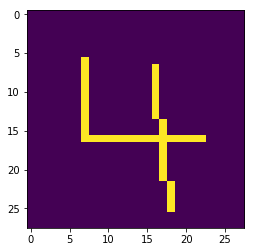

In [8]:
img_show(predict_data.reshape(28, 28))

In [9]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": predict_data},
        shuffle=False)

In [10]:
predict_results = list(mnist_classifier.predict(predict_input_fn))

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_convnet_model/model.ckpt-5025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [11]:
result = predict_results[0]['classes']

In [12]:
print('画像の数字は「{}」です。'.format(result))

画像の数字は「4」です。
